# [MinimalAI] 2022年计算机视觉SOTA实践

**Author: KKY@布尔艺数**
<div algin=center>
<img src="https://github.com/EvilPsyCHo/BoolArt/blob/main/logo/logo_horizontal.png?raw=true" width = "300" height = "200" />
</div>

1. **Timm** for SOTA Pretrained Model
2. **albumentations** for Data Augmentation
3. **Pure Pytorch** for Implement train pipeline
4. 采用[Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer)测试

In [1]:

import pandas as pd
import numpy as np
import cv2
from easydict import EasyDict
import yaml

import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn import CrossEntropyLoss, NLLLoss

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [2]:
!ls ./digit-recognizer

sample_submission.csv  test.csv  train.csv


In [3]:
train = pd.read_csv("./digit-recognizer/train.csv")
test = pd.read_csv("./digit-recognizer/test.csv")
submission = pd.read_csv("./digit-recognizer/sample_submission.csv")

In [4]:
train.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


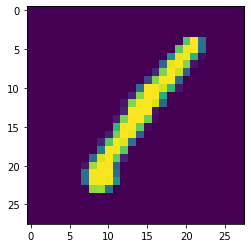

In [5]:
plt.imshow(train.iloc[0, 1:].values.reshape(28, 28))

In [6]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [8]:
train_images = train.iloc[:, 1:].values.reshape(-1, 28, 28)
train_labels = train.iloc[:, 0].values

test_images = test.values.reshape(-1, 28, 28)

In [9]:
train_images.shape

(42000, 28, 28)

In [10]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [11]:
len(train_labels) == len(train_images)

True

In [12]:
test_images.shape

(28000, 28, 28)

In [13]:
train_images.mean() / 255

0.13101533792088266

In [14]:
train_images.std() / 255

0.3085401559245608

In [15]:
train_images.max()

255

## Image Augmentation

1. 图片增强;
2. 图片尺寸；
3. 标准化；
4. 匹配到模型input format;

In [16]:
def get_transform(image_size, train=True):
    if train:
        return A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomBrightnessContrast(p=0.2),
                    A.Resize(*image_size, interpolation=cv2.INTER_LANCZOS4),
                    A.Normalize(0.1310, 0.30854),
                    ToTensorV2(),
                ])
    else:
        return A.Compose([
                    A.Resize(*image_size, interpolation=cv2.INTER_LANCZOS4),
                    A.Normalize(0.1310, 0.30854),
                    ToTensorV2(),
                ])

## Dataset

In [17]:
class MiniDataSet(Dataset):
    
    def __init__(self, images, labels=None, transform=None):
        self.images = images.astype("float32")
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        ret = {}
        img = self.images[idx]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        ret["image"] = img
        
        if self.labels is not None:
            ret["label"] = self.labels[idx]
        
        return ret

## Model

In [18]:
class MiniModel(nn.Module):
    
    def __init__(self, backbone, num_class, pretrained=False, backbone_ckpt=None):
        
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained, 
                                          checkpoint_path=backbone_ckpt, in_chans=1)
        self.head = nn.Linear(self.backbone.get_classifier().in_features, num_class)
        self.backbone.head.fc = nn.Identity()
        self.loss_fn = NLLLoss()
    
    def forward(self, image, label=None):
        embed = self.backbone(image)
        logit = self.head(embed)
        
        if label is not None:
            logit_logsoftmax = torch.log_softmax(logit, 1)
            loss = self.loss_fn(logit_logsoftmax, label)
            return {"prediction": logit, "loss": loss}
        return {"prediction": logit}

## Pipeline

- train_fn
- eval_fn
- pred_fn

In [19]:
from tqdm import tqdm

In [20]:
def train_one_epoch(model, optimizer, dataloader, device):
    model.to(device)
    model.train()
    train_loss = []
    
    for batch in tqdm(dataloader):
        output = model(batch["image"].to(device), batch["label"].to(device))
        optimizer.zero_grad()
        output["loss"].backward()
        optimizer.step()
        train_loss.append(output['loss'].item())
    
    return np.mean(train_loss)


def eval_one_epoch(model, dataloader, device):
    model.to(device)
    model.eval()
    eval_loss = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device), batch["label"].to(device))
        eval_loss.append(output['loss'].item())
    
    return np.mean(eval_loss)


def predict(model, dataloader, device):
    model.to(device)
    model.eval()
    predictions = []
    
    for step, batch in enumerate(dataloader):
        output = model(batch["image"].to(device))
        prediction = torch.argmax(output['prediction'], 1)
        predictions.append(prediction.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    return predictions

## Experiment

In [88]:
CONFIG = EasyDict({
    "backbone": "convnext_small",
    "num_class": 10,
    "image_size": (56, 56),
    "pretrained": True,
    "epochs": 5,
    "batch_size": 258,
    "num_workers": 4,
    "device": "cuda:0"
})

In [89]:
train_transform = get_transform(CONFIG.image_size, True)
valid_transform = get_transform(CONFIG.image_size, False)


full_train_ds = MiniDataSet(train_images, train_labels, train_transform)
train_ds = MiniDataSet(train_images[:40000], train_labels[:40000], train_transform)
val_ds = MiniDataSet(train_images[40000:], train_labels[40000:], valid_transform)
test_ds = MiniDataSet(test_images, transform=valid_transform)

In [90]:
full_train_dl = DataLoader(full_train_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=True, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=False, drop_last=False)
test_dl = DataLoader(test_ds, batch_size=CONFIG.batch_size, num_workers=CONFIG.num_workers, shuffle=False, drop_last=False)

In [91]:
model = MiniModel(backbone=CONFIG.backbone, num_class=CONFIG.num_class, pretrained=CONFIG.pretrained)
optimizer = Adam(model.parameters(), lr=0.0005)

In [92]:
for epoch in range(CONFIG.epochs):
    train_loss = train_one_epoch(model, optimizer, train_dl, CONFIG.device)
    val_loss = eval_one_epoch(model, val_dl, CONFIG.device)
    print(f"Epoch_{epoch+1}, train loss {train_loss:.4f}, val loss {val_loss:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.28it/s]


Epoch_1, train loss 0.3486, val loss 0.0985


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.23it/s]


Epoch_2, train loss 0.0811, val loss 0.0802


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.17it/s]


Epoch_3, train loss 0.0629, val loss 0.0739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.18it/s]


Epoch_4, train loss 0.0487, val loss 0.0535


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:16<00:00,  9.12it/s]


Epoch_5, train loss 0.0443, val loss 0.0431


In [93]:
val_prediction = predict(model, val_dl, device=CONFIG.device)
test_prediction = predict(model, test_dl, device=CONFIG.device)

In [94]:
from sklearn.metrics import accuracy_score

In [95]:
accuracy_score(train_labels[40000:], val_prediction)

0.988

In [96]:
submission["Label"] = test_prediction
submission.to_csv("./submit.csv", index=False)